# JAX-first-grad-vmap.ipynb


Prise de contact avec l'auto-diff sur un exemple simple, puis quelques illustrations de JAX (vmap/jit) sur un exemple de minimisation avec la méthode de Gradient-Descent, et de Newton


- last verification : June 19th 2022


In [35]:
from pathinit import *

import numpy as np

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian
#from jax.ops import index, index_update
jax.config.update("jax_enable_x64", True)

from functools import partial


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18

## Attention: Il y a (au moins) 2 pratiques en vigueur: 
- soit (numpy -> np, jax.numpy -> jnp) 
- soit (numpy -> onp, jax.numpy -> np)

# Example de l'usage de l'auto-diff et la vectorisation

$$
f(x) = e^{-\frac{x}{2}} \sin(x)
$$

In [2]:
def f(x):
    return jnp.exp(-x*0.5)*jnp.sin(x)

In [3]:
# Expressions Exactes de f'(x) et f''(x)
def fp(x):
    return jnp.exp(-x*0.5)*(2.*jnp.cos(x)-jnp.sin(x))/2.
def fpp(x):
    return -jnp.exp(-x*0.5)*(4.*jnp.cos(x)+3.*jnp.sin(x))/4.

# Expressions numériques centrées approchées de f'(x) et f''(x)
def fpnum(x,h=0.1):
    return (f(x+h)-f(x-h))/(2*h)
def fppnum(x,h=0.1):
    return (f(x+h)-2*f(x)+f(x-h))/h**2

# Différentiations successives

In [4]:
jfp  = grad(f)             # grad pour gradient
jfpp = grad(grad(f))

## Voir que fait JAX quand il produit le code...

In [5]:
jax.make_jaxpr(jfp)(0.)

{ lambda ; a:f64[]. let
    b:f64[] = neg a
    c:f64[] = mul b 0.5
    d:f64[] = exp c
    e:f64[] = sin a
    f:f64[] = cos a
    _:f64[] = mul d e
    g:f64[] = mul d 1.0
    h:f64[] = mul 1.0 e
    i:f64[] = mul g f
    j:f64[] = mul h d
    k:f64[] = mul j 0.5
    l:f64[] = neg k
    m:f64[] = add_any i l
  in (m,) }

### prenez un papier et un crayon et vérifier que ce code est correcte :) 

## La vectorisation est utile pour appeler la fonction avec un array (nb. et d'autres structures)

In [36]:
jfp  = vmap(grad(f))
jfpp = vmap(grad(grad(f)))

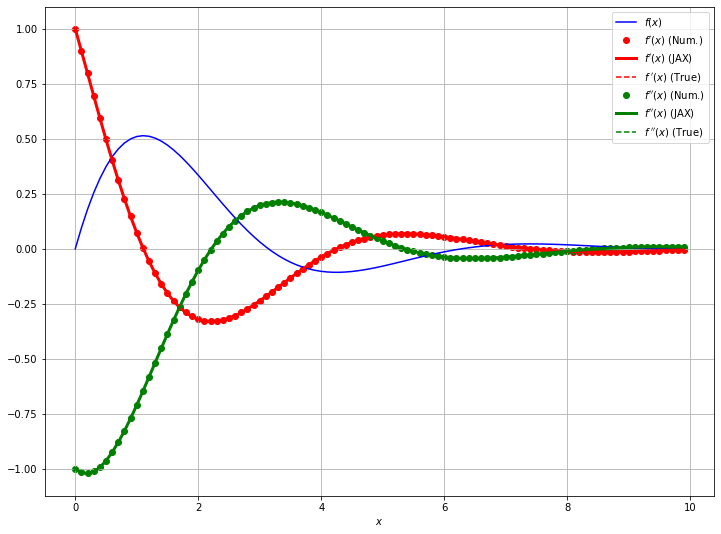

In [12]:
fig,_ = plt.subplots(figsize=(12,9))
x=jnp.arange(0,10,0.1)

# plot function itself
plt.plot(x,f(x),c='b', label="$f(x)$")


# plot derivative
plt.scatter(x,fpnum(x), c='r',label="$f^{\prime}(x)$ (Num.)")
plt.plot(x,jfp(x),c='r' ,lw=3,label="$f^{\prime}(x)$ (JAX)")
plt.plot(x,fp(x),ls="--",c='r', label="$f^{\ \prime}(x)$ (True)")
#plt.plot(x,jfjacobien(x),ls='-.', lw=3, label='jacobien')

# plot second derivative
plt.scatter(x,fppnum(x), c="g",label="$f^{\prime\prime}(x)$ (Num.)")
plt.plot(x,jfpp(x), c="g",lw=3,label="$f^{\prime\prime}(x)$ (JAX)")
plt.plot(x,fpp(x),ls="--", c='g',label="$f^{\ \prime\prime}(x)$ (True)")
#plt.plot(x,jfhessien(x), ls='-.', lw=3, label='hessian')

plt.grid()
plt.xlabel("$x$")
plt.legend(loc="upper right");

### Zoom: => Q: à quoi sert l'auto-différentiation? 

- JAX differentiation is more accurate than numerical differentiation

- show difference between the new calculation and true analytical differentiation

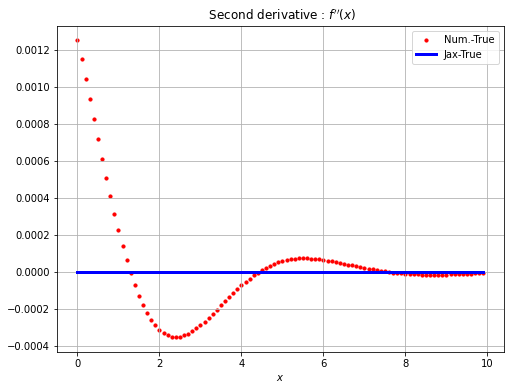

In [19]:
fig,_ = plt.subplots(figsize=(8,6))
x=jnp.arange(0,10,0.1)
plt.scatter(x,fppnum(x)-fpp(x),s=10, c="r", label="Num.-True")
plt.plot(x,jfpp(x)-fpp(x),lw=3,c="b",  label="Jax-True")
plt.grid()
plt.xlabel("$x$")
plt.title(" Second derivative : $f^{\prime\prime}(x)$")
plt.legend(loc="upper right");

In [17]:
x=jnp.arange(0,10,0.1)
jnp.max(jnp.abs(jfpp(x)-fpp(x)))

DeviceArray(2.22044605e-16, dtype=float64)

# Jacobian and Hessian
vous pouvez essayer d'utiliser le *jacobien* et le *hessien* ...

In [21]:
jfjacobien = vmap(jacfwd(f))
jfhessien  = vmap(hessian(f))

In [24]:
jfhessien(x).shape

(100,)

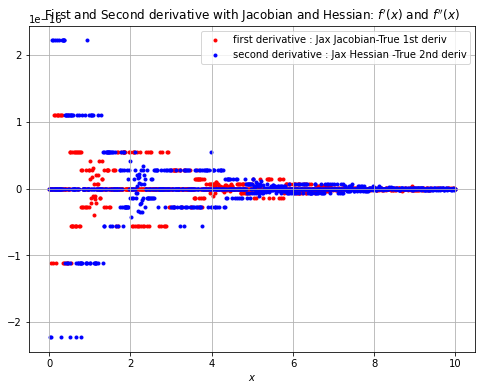

In [33]:
fig,_ = plt.subplots(figsize=(8,6))
x=jnp.arange(0,10,0.01)
plt.scatter(x,jfjacobien(x)-fp(x),marker="." ,lw=1,c="r", label="first derivative : Jax Jacobian-True 1st deriv")
plt.scatter(x,jfhessien(x)-fpp(x),marker=".", lw=1,c="b",  label="second derivative : Jax Hessian -True 2nd deriv")
plt.grid()
plt.xlabel("$x$")
plt.title("First and Second derivative with Jacobian and Hessian: $f^{\prime}(x)$ and $f^{\prime\prime}(x)$")
plt.legend(loc="upper right");

## What is the difference between the Jacobian and first derivative in the one hand and the Hessian and the second derivative on the other hand

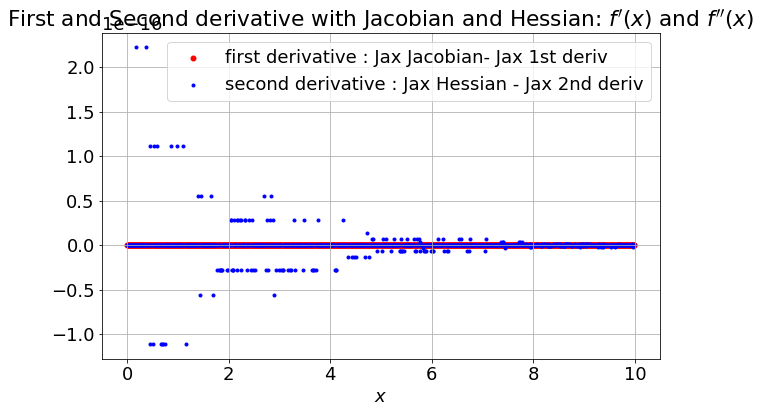

In [40]:
fig,_ = plt.subplots(figsize=(10,6))
x=jnp.arange(0,10,0.01)
plt.scatter(x,jfjacobien(x)-jfp(x),marker="." ,lw=3,c="r", label="first derivative : Jax Jacobian- Jax 1st deriv")
plt.scatter(x,jfhessien(x)-jfpp(x),marker=".", lw=1,c="b",  label="second derivative : Jax Hessian - Jax 2nd deriv")
plt.grid()
plt.xlabel("$x$")
plt.title("First and Second derivative with Jacobian and Hessian: $f^{\prime}(x)$ and $f^{\prime\prime}(x)$")
plt.legend(loc="upper right");

## La différentiation est par défaut sur le 1er argument de la fonction mais cela n'est pas exclusif

In [41]:
def func(x, y):
    return 2 * x * y

print(grad(func)(3., 4.))  # 8.                 # la fonction evaluee en (3,4)
print(grad(func, argnums=0)(3., 4.))  # 8.      # la derivee par rapport a x evaluee en (3,4)
print(grad(func, argnums=1)(3., 4.))  # 6       # la derivee par rapport a y evaluee en (3,4)
print(grad(func, argnums=(0, 1))(3., 4.))  # (8., 6.)  # ici on fait en mm temps la derivée par rapport a x et a y...

8.0
8.0
6.0
(DeviceArray(8., dtype=float64, weak_type=True), DeviceArray(6., dtype=float64, weak_type=True))


In [42]:
grad(func)(3., 4.)

DeviceArray(8., dtype=float64, weak_type=True)

essayer avec une autre fonction...

# Exemple via la minimisation de la Mean Squared Error (MSE)

- Fonction model:
$$
f(p,x) = e^{-p[0]\cdot x}\sin(p[1]\cdot x)
$$

- Loss function : squarre error
$$
loss(p,x_i,y_i) = \frac{1}{N} \sum_i^N (y_i - f(p,x_i))^2
$$

In [43]:
def model(p, x):
    return jnp.exp(-x*p[0])*jnp.sin(x*p[1])

def loss_fun(p, xi, yi):
    yhat = model(p, xi)
    return jnp.mean( (yhat - yi)**2 )

- Remarque : $jnp.exp, jnp.sin \cdots$ sont vectorisees donc `model` et `loss_fun` n'ont pas besoin d'un vmap


In [44]:
# dataset
ptrue = jnp.array([0.5,1])

xin = jnp.arange(0,10,1.)
yerr = 0.05

# jax.random.PRNGKey(seed) gestion des randoms numbers
y_true =  model(ptrue, xin)
yin = y_true + yerr*jax.random.normal(jax.random.PRNGKey(42),shape=xin.shape)

In [45]:
xin

DeviceArray([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float64)

on peut directement utiliser les DeviceArray de JAX dans matplotlib

Text(0, 0.5, '$y$')

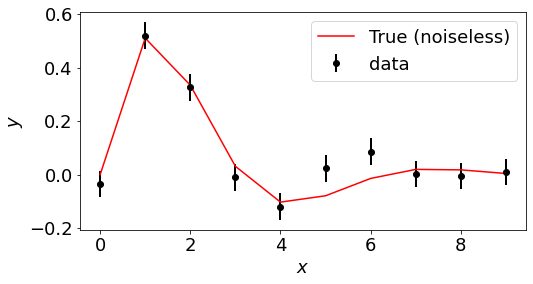

In [51]:
fig,_ = plt.subplots(figsize=(8,4))
plt.errorbar(xin,yin,yerr=yerr, fmt='o', linewidth=2, capsize=0, c='k', label="data");
plt.plot(xin,y_true, "r",label='True (noiseless)')
plt.legend();
plt.xlabel("$x$")
plt.ylabel("$y$")

## Descente de Gradient

- First use of `jit`

In [53]:
@jit
def gradient_descent_step(p, xi, yi, lr=0.1):
    """
    The single sequence step of the algorithm doing the minimisation
    
    input args :
    - p : the vector of parameters
    - x_i : the x_i data
    - y_i : the y_i data
    - lr : step size
    
    output args:
    - the parameter vector
    
    
    Note this function requires to know the loss function
    """
    return p - lr * jax.grad(loss_fun)(p, xi, yi)

nb. nous verrons le pourquoi du `@jit` un peu plus loin

In [63]:
# Un minizer basique (version plus JAX/LAX-like à la fin)
def minimzer(loss_fun, x_data, y_data, par_init, method, verbose=True):
    """
    input args:
    - loss_fun : name of loss function
    - x_data : data along x axis
    - y_data : data along y axis
    - par_init : initial values of the parameter vector
    - method : iteration sequence algorithm that return the new parameters
    
    output args:
    - the final vector parameters
    
    """
    
    # initialisation
    p_cur = par_init
    new_loss=jnp.inf
    
    # loop on the steps (of gradient descient)
    for t in range(5000):
   
        if (t % 100 == 0) and verbose:
            if t == 0 :
                print(f"minimzer : \t iter \t parameters \t \t loss ")
            print(f"minimzer : \t{t}  \t {p_cur}  \t {new_loss}" )

        old_loss = new_loss
        
        # get new parameters with the method
        new_p = method(p_cur, x_data,y_data)
        new_loss = loss_fun(new_p, x_data,y_data)

        if jnp.abs(new_loss-old_loss) < 1e-9:
            print(f"Converged after {t} epochs: p = {new_p}, loss = {new_loss}")
            break

        p_cur = new_p

    return p_cur

In [64]:
par_mini_GD = minimzer(loss_fun, x_data=xin, y_data=yin, par_init=jnp.array([0., 0.5]),
                    method=gradient_descent_step, verbose=True)

minimzer : 	 iter 	 parameters 	 	 loss 
minimzer : 	0  	 [0.  0.5]  	 inf
minimzer : 	100  	 [0.62048393 0.70750834]  	 0.008637562559042189
minimzer : 	200  	 [0.59232543 0.93250246]  	 0.0033691784193686583
minimzer : 	300  	 [0.54957041 1.04688945]  	 0.0017975857523135552
minimzer : 	400  	 [0.53074669 1.08778781]  	 0.0015735323299857114
minimzer : 	500  	 [0.52542832 1.09953584]  	 0.0015546792362664712
minimzer : 	600  	 [0.52410865 1.10263342]  	 0.0015533842898307721
Converged after 633 epochs: p = [0.52394625 1.10302972], loss = 0.0015533297417048113


## Recommencez en decommentant "@jit" dans la cellule du `gradient_descent_step` : qu'observe-t'on?

Text(0.5, 1.0, 'Result of the fits')

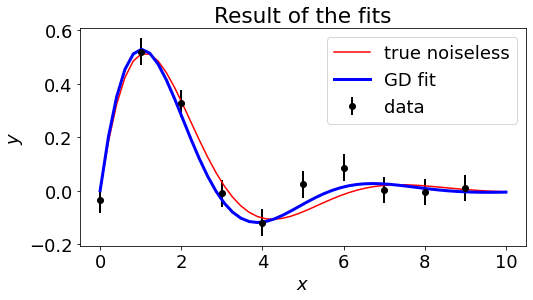

In [68]:
fig,_ = plt.subplots(figsize=(8,4))
plt.errorbar(xin,yin,yerr=yerr, fmt='o', linewidth=2, capsize=0, c='k', label="data")
x_val = jnp.linspace(0.,10,50)
plt.plot(x_val,model(ptrue, x_val),"r",label="true noiseless")
plt.plot(x_val,model(par_mini_GD, x_val),'b' ,lw=3,label="GD fit")
plt.legend();
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Result of the fit via gradient descent minimizer")

## Méthod  de Newton => usage du hessien (cf. méthode d'ordre 2, alors que GD : méthode d'ordre 1)

In [70]:
gLoss = lambda p,xi,yi: jacfwd(loss_fun)(p,xi,yi)
hLoss = lambda p,xi,yi: jax.hessian(loss_fun)(p,xi,yi)

@jit
def oneStepNewton(p,xi,yi,lr=0.1):
    return p - lr*jnp.linalg.inv(hLoss(p,xi,yi)) @ gLoss(p,xi,yi)

In [71]:
par_mini_Newton = minimzer(loss_fun, x_data=xin, y_data=yin, par_init=jnp.array([0., 0.5]),
                    method=oneStepNewton, verbose=True)

minimzer : 	 iter 	 parameters 	 	 loss 
minimzer : 	0  	 [0.  0.5]  	 inf
minimzer : 	100  	 [0.07535076 0.00358029]  	 0.039375743398758295
Converged after 183 epochs: p = [0.52373613 1.10348083], loss = 0.0015532978650186742


Text(0.5, 1.0, 'Result of the fit via gradient descent and Newton minimizer')

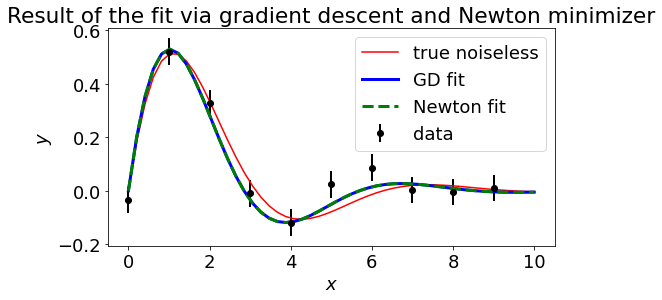

In [73]:
fig,_ = plt.subplots(figsize=(8,4))
plt.errorbar(xin,yin,yerr=yerr, fmt='o', linewidth=2, capsize=0, c='k', label="data")
x_val = jnp.linspace(0.,10,50)
plt.plot(x_val,model(ptrue, x_val),'r',label="true noiseless")
plt.plot(x_val,model(par_mini_GD, x_val),'b' ,lw=3,label="GD fit")
plt.plot(x_val,model(par_mini_Newton, x_val),'g',ls='--',lw=3,label="Newton fit")
plt.legend();
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Result of the fit via gradient descent and Newton minimizer")

# Gradient/Vmap... par rapport à: tuples, lists, and dicts

$$
f(p,x) = p[a]^2 + p[b]\cdot x
$$

In [75]:
def f(p,x):
    return p["a"]**2 + p["b"]*x

## Vectorization partielle du gradient : `in-axes`

### gradient sans `argnum`

- gradient is calculated with respect to the first argument, that is both parameters:

$$
\left( \frac{\partial f}{ \partial p[a]} = 2 p[a] , \frac{\partial f}{\partial p[b]} = x \right)
$$

In [80]:
print(grad(f)({"a":3.,"b":1.},10.))

{'a': DeviceArray(6., dtype=float64, weak_type=True), 'b': DeviceArray(10., dtype=float64, weak_type=True)}


- Note the result is the two component DeviceArray dictionary with the same shape as the $p$ argument 

### gradient avec `argnums`

- gradient is calculated with respect to second argument, thus $x$:

$$
\frac{\partial f}{\partial x} = p[b]
$$

In [81]:
print(grad(f, argnums=1)({"a":3.,"b":1.},10.))

1.0


### Vectorisation of parameters with  `vmap` and `in_axes` 

- vectorisation of $p[b]$ :

In [83]:
print(vmap(f, in_axes=({"a": None, "b": 0},None))({"a":1.,"b":jnp.array([1.,2.,3.])},10.))

[11. 21. 31.]


- vectorisation of $p[a]$

In [84]:
vmap(f, in_axes=({"a":0, "b": None},None))({"a":jnp.array([1.,2.,3.]),"b":2.0},10)

DeviceArray([21., 24., 29.], dtype=float64)

# Un peu plus de `in_axis` dans vmap (equivalent Numpy)

$$
f(a,b,x) = a^2 +b \cdot x 
$$

In [86]:
def func(a,b,x):
    return a**2 + b*x

### vectorisation de la fonction selon $a$

- use the `in_axes` inside the vmap function

In [87]:
vfunc = vmap(func, in_axes=(0,None,None))

In [88]:
vfunc(jnp.array([1.,2.,3.]), 1.,10.)

DeviceArray([11., 14., 19.], dtype=float64)

### Vectorisation le long de 2 axes $(a,b)$

- we repeat the `in_axes` argument in the `vmap`

In [89]:
# map sur 2 axis
vvfunc = vmap(vmap(func, in_axes=(0,None,None)),in_axes=(None,0,None))

- a repeated 3 times
- b repeated 4 times

- we end up with a DeviceArray of size (4,3)

In [91]:
vvfunc(jnp.array([1.,2.,3.]),jnp.array([0.,1.,4.,5.]),10.)
# a:(1,2,3) b: 0
# a:(1,2,3) b: 1
# a:(1,2,3) b: 4
# a:(1,2,3) b: 5

DeviceArray([[ 1.,  4.,  9.],
             [11., 14., 19.],
             [41., 44., 49.],
             [51., 54., 59.]], dtype=float64)

In [93]:
# equivalent Numpy
np.mat([[func(ai,bj,x=10.) for ai in [1,2,3]] for bj in [0.,1.,4.,5.]])

matrix([[ 1.,  4.,  9.],
        [11., 14., 19.],
        [41., 44., 49.],
        [51., 54., 59.]])

- another way 

In [ ]:
vmap(func,in_axes=(0,0,None))(jnp.array([1.,2.,3.]),jnp.array([0.,1.,4.]),10.)
# ici map a,b de meme dimension car
# a:1 b:0
# a:2 b:1
# a:3 b:4

In [ ]:
# equivalent Numpy
[func(ai,bj,x=10.) for ai,bj in zip([1,2,3],[0.,1.,4.,5.])]

## On peut vouloir specifier les axes de `a` et `b` qui sont mis ensemble 

In [ ]:
vmap(func,in_axes=(0,1,None))(jnp.array([1.,2.,3.]),jnp.array([0.,1.,4.])[jnp.newaxis,:],10.)

In [ ]:
#idem
vmap(func,in_axes=(0,1,None))(jnp.array([1.,2.,3.]),jnp.array([[0.,1.,4.]]),10.)

In [ ]:
a = np.array([1.,2.,3.])
b = np.array([[0.,1.,4.],
               [1.,2.,8.]])
vmap(func,in_axes=(0,1,None))(a,b,10.)

In [ ]:
a.shape, b.shape

In [ ]:
#a[0]:1  b[0,0]:0 => 1, a[0]:1, b[1,0]:1 => 11 
#a[1]:2  b[0,1]:1 => 14, a[1]:2, b[1,1]:2 => 24
#a[2]:3  b[0,2]:4 => 49 , a[2]:3  b[1,2]:8 => 89 

# equivalent Numpy
[[func(a[i],b[j,i],x=10.) for i in range(a.shape[0])] for j in range(b.shape[0])]

# PyTree: une structure user pour que JAX puisse faire du grad/vmap/jit

In [ ]:
from jax.tree_util import register_pytree_node_class

@register_pytree_node_class
class Params:
    def __init__(self, a, b):
        self._a = a
        self._b = b

    def __repr__(self):
        return f"Params(x={self._a}, y={self._b})"

    @property
    def a(self):
        return self._a
    
    @property
    def b(self):
        return self._b

    def tree_flatten(self):
        children = (self._a, self._b)
        aux_data = None
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children)

In [ ]:
my_params = Params(3.,1.)
my_params

In [ ]:
my_params.a, my_params.b

In [ ]:
def g(p,x):
    return (p.a)**2 + (p.b)*x

In [ ]:
print(grad(g)(my_params,10))

In [ ]:
print(vmap(g, in_axes=(Params(None, 0), None))(Params(3., jnp.array([1.,2.,3.])), 10))

In [ ]:
from jax.tree_util import tree_flatten, tree_unflatten
def show_example(structured):
    flat, tree = tree_flatten(structured)
    unflattened = tree_unflatten(tree, flat)
    print("structured={}\n  flat={}\n  tree={}\n  unflattened={}".format(
          structured, flat, tree, unflattened))

In [ ]:
show_example(my_params)

# Takeaway message:
- JAX ne nécessite pas l'apprentissage d'un nouveau langage de programmation 
- Avec `jax.numpy` il est (presque) aussi simple d'utiliser les JAX DeviceArray en lieu et place des Numpy array
- L'autofifferentiation: c'est pas compliqué (`grad`, `jacfwd`, `hessian`)
- `jit` permet d'accélérer le code (compilation au vol)
- `vmap` permet de vectoriser l'appel de fonctions (nb. il existe `pmap` pour la paraléllisation sur plusieurs devices)
- vectorization partielle `in_axis`
- On peut utiliser (grad/vmap...) ses structures autres que les arrays: tuple, liste, dico et user PyTree

# Exercice:
- reprendre la vectorization sur 2 axes avec Dictionaire.
- Reprener les méthodes `model(p, x)`, `loss_fun(p, xi, yi)`,  `oneStepNewton(p,xi,yi,lr=0.1)` en changeant la sturture des paramètres `p` (le default est `jnp.array`): ex utiliser un `dictionnary` et/ou une classe sur le modèle de `Params`. 



# EXTRA qd on aura pratiqué l'exemple de la fratale de Julia

Exercice: Réécrire la fonction `minimize` (notée `minimize_bis`) en utilisant le pattern `cond_fun/body/jax.lax.while_loop`

In [ ]:
def minimzer_bis(loss_fun, x_data, y_data, par_init, method, maxiter=5000, loss_diff=1e-9):
    cond_fun = True #...
    @jit
    def body(val):
        #...
        return #...
    val = [par_init, 0.,0.,jnp.inf] 
    #...
    return val

In [ ]:
def minimzer_bis(loss_fun, x_data, y_data, par_init, method, maxiter=5000, loss_diff=1e-9):

    cond_fun = lambda val: (val[1] < maxiter) & (jnp.abs(val[2]-val[3]) > loss_diff)
    
    @jit
    def body(val):
        p_cur    = val[0]
        old_loss = val[3]
        new_p = method(p_cur, x_data,y_data)
        new_loss = loss_fun(new_p, x_data,y_data)
        return [new_p, val[1]+1,  old_loss, new_loss]
        

    val = [par_init, 0.,0.,jnp.inf]   # on peut faire avec des Tuples, a accorder avec le return de body
    val = jax.lax.while_loop(cond_fun,body,val)

    return val

In [ ]:
param, n_iter, loss,_ = minimzer_bis(loss_fun, x_data=xin, y_data=yin, par_init=jnp.array([0., 0.5]),
                    method=gradient_descent_step)

In [ ]:
print(f"{n_iter} epochs: p = {param}, loss = {loss:.2e}")